In [206]:
import nltk
import json
import pandas as pd
import gzip
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import skfuzzy as fuzz
from sklearn.feature_extraction.text import TfidfVectorizer
from skfuzzy import control as ctrl
import random
from IPython.display import display


In [207]:
PATH = './Magazine_Subscriptions.json.gz'
PATH_meta = './meta_Magazine_Subscriptions.json.gz'

## MODULO 1
### Lector de datasets

In [208]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

In [209]:
df = getDF(PATH)
df_meta = getDF(PATH_meta)

In [210]:
df_meta.shape

(3385, 19)

In [211]:
df_meta['asin'].nunique()

2320

notamos que hay productos que no son unicos, arreglamos eso

In [212]:
df_meta= df_meta.drop_duplicates(subset='asin', keep='first')
df_meta.shape

(2320, 19)

Eliminamos las filas que tengan vacio una de estas columnas

In [213]:
columns_to_combine = ['title', 'brand', 'summary', 'description', 'expliota']
existing_columns = [col for col in columns_to_combine if col in df_meta_cortado.columns]

if existing_columns:
    for column in existing_columns:
        df_meta = df_meta[df_meta[column].astype(bool)]

In [214]:
df_meta.shape

(1934, 19)

In [215]:
df_meta.head()

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
0,"[Magazine Subscriptions, Professional & Educat...",,[REASON is edited for people interested in eco...,,"<span class=""a-size-medium a-color-secondary""","[B002PXVYLE, B01MCU84LB, B000UHI2LW, B01AKS14A...",,Reason Magazine,[],[],"[B002PXVYLE, B000UHI2LW, B01MCU84LB, B002PXW18...","{'Format:': 'Print Magazine', 'Shipping: ': 'C...",Magazine Subscriptions,,,,B00005N7NQ,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
1,"[Magazine Subscriptions, Arts, Music &amp; Pho...",,[Written by and for musicians. Covers a variet...,,"<span class=""a-size-medium a-color-secondary""","[B002PXVYGE, B0054LRNC8, B000BVEELE, B00006KC3...",,String Letter Publishers,[],742 in Magazine Subscriptions (,"[B002PXVYGE, B0054LRNC8, B00006L16A, 171906487...","{'Format:': 'Print Magazine', 'Shipping: ': 'C...",Magazine Subscriptions,,,,B00005N7OC,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
2,"[Magazine Subscriptions, Fashion &amp; Style, ...",,[Allure is the beauty expert. Every issue is f...,,"<span class=""a-size-medium a-color-secondary""","[B001THPA4O, B002PXVZWW, B001THPA1M, B001THPA1...",,Conde Nast Publications,[],[],"[B002PXVZWW, B001THPA4O, B001THPA1M, B01N819UD...","{'Format:': 'Print Magazine', 'Shipping: ': 'C...",Magazine Subscriptions,,,,B00005N7OD,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
3,"[Magazine Subscriptions, Sports, Recreation & ...",,[FLIGHT JOURNAL includes articles on aviation ...,,"<span class=""a-size-medium a-color-secondary""","[B07JVF7QW4, B00ATQ6FPY, B002G551F6, B00008CGW...",,AirAge Publishing,[],[],"[B002G551F6, B00ATQ6FPY, B00005N7PT, B001THPA2...","{'Format:': 'Print Magazine', 'Shipping: ': 'C...",Magazine Subscriptions,,,,B00005N7O9,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
4,"[Magazine Subscriptions, Professional & Educat...",,[RIDER is published for the road and street ri...,,"<span class=""a-size-medium a-color-secondary""","[B002PXVYD2, B01BM7TOU6, B000060MKJ, B000BNNIG...",,EPG Media & Specialty Information,[],[],"[B01BM7TOU6, B000060MKJ, B002PXVYD2, B000BNNIG...","{'Format:': 'Print Magazine', 'Shipping: ': 'C...",Magazine Subscriptions,,,,B00005N7O6,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...


Text(0, 0.5, 'Count')

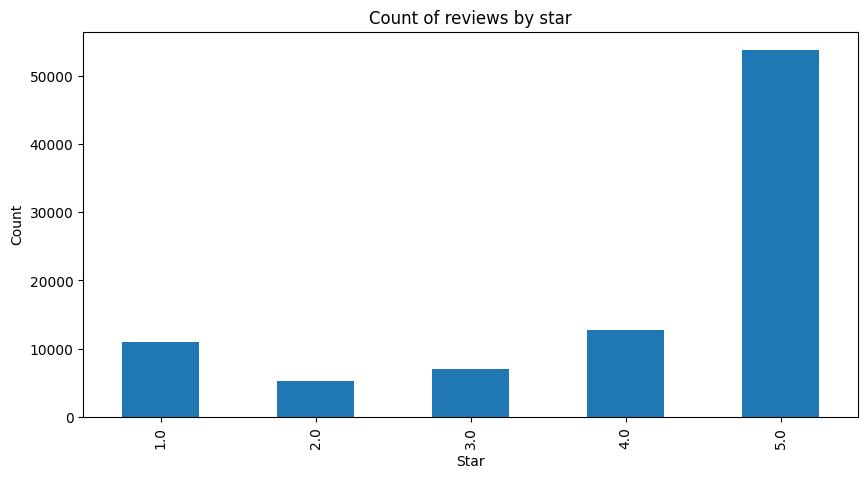

In [216]:
ax = df['overall'].value_counts().sort_index().plot(kind='bar', title="Count of reviews by star",figsize=(10, 5))
ax.set_xlabel("Star")
ax.set_ylabel("Count")

notamos que los reviews estan sesgados hacia 5 estrellas

### Tokenizacion de comentarios

In [217]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\coraj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\coraj\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\coraj\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\coraj\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

## MODULO 2
### Rating Score
calculamos el overall mean

In [218]:
overall_mean = df.groupby('asin')['overall'].mean().reset_index()
overall_mean
# num_asin_values = df_meta['asin'].nunique()
# num_asin_values

,asin,overall
0,B00005N7NQ,3.803419
1,B00005N7O3,3.600000
2,B00005N7O4,4.333333
3,B00005N7O6,4.531250
4,B00005N7O9,4.434783
...,...,...
2423,B01HI8V1AE,4.750000
2424,B01HI8V1C2,4.000000
2425,B01HI8V1I6,4.500000
2426,B01HI8V1MC,4.071429


agregamos la columnas id al dataframe df_meta

In [219]:
df_meta['id']=[i for i in range(0,df_meta.shape[0])]

reducimos la muestra para facilitar el procesamiento 

In [220]:
CANTIDAD = 10000

In [221]:
df_meta_cortado = df_meta.head(CANTIDAD)

creamos una nueva columnas que contiene la informacion que necesitamos para encontrar items similares

In [222]:
columns_to_combine = ['title', 'brand', 'summary', 'description', 'expliota']
existing_columns = [col for col in columns_to_combine if col in df_meta_cortado.columns]

if existing_columns:
    # Al menos una de las columnas en 'existing_columns' existe en el df_meta_cortadoFrame 'df_meta_cortado'.
    # Puedes combinar las columnas existentes y crear la nueva columna 'combined_text'.
    df_meta_cortado.loc[:, 'combined_text'] = df_meta_cortado[existing_columns].apply(lambda row: ' '.join(str(val) for val in row), axis=1)


C:\Users\coraj\AppData\Local\Temp\ipykernel_20708\1163952785.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_meta_cortado.loc[:, 'combined_text'] = df_meta_cortado[existing_columns].apply(lambda row: ' '.join(str(val) for val in row), axis=1)


La matriz vecs contiene las puntuaciones TF-IDF ( Frecuencia de Término - Frecuencia Inversa de Documento) para cada palabra en cada documento. Las puntuaciones TF-IDF representan la importancia de una palabra para un documento en la colección.

In [223]:

vec = TfidfVectorizer()
vecs = vec.fit_transform(df_meta_cortado['combined_text'].apply(lambda x: np.str_(x)))
vecs.shape

(1934, 9859)

## Modulo 3
### Similarity Score

Esto significa que tienes 10000 documentos (las filas del DataFrame df_meta_cortado) y 22929 palabras únicas en todos los documentos (las características).

calcular la similitud del coseno entre cada par de vectores en vecs

Su valor varía de -1 (vectores completamente opuestos) a 1 (vectores idénticos), con 0 indicando ortogonalidad (vectores perpendiculares).

In [224]:
similaridad = cosine_similarity(vecs)
similaridad

array([[1.        , 0.02948667, 0.04802728, ..., 0.07626159, 0.02335784,
        0.01958847],
       [0.02948667, 1.        , 0.10854755, ..., 0.0316815 , 0.01740582,
        0.03391683],
       [0.04802728, 0.10854755, 1.        , ..., 0.10030577, 0.03020507,
        0.10641362],
       ...,
       [0.07626159, 0.0316815 , 0.10030577, ..., 1.        , 0.24305012,
        0.22732716],
       [0.02335784, 0.01740582, 0.03020507, ..., 0.24305012, 1.        ,
        0.23461906],
       [0.01958847, 0.03391683, 0.10641362, ..., 0.22732716, 0.23461906,
        1.        ]])

In [225]:
def recommend(asin):
    item_id = df_meta_cortado[df_meta_cortado.asin == asin]['id'].values[0]
    scores = list(enumerate(similaridad[item_id]))
    sorted_scores = sorted(scores, key=lambda x:x[1], reverse=True)
    # si score es mayor o igual a 1 entonces se elimina de la lista
    scores_no_1 = [i for i in sorted_scores if i[1]<0.8]
    # fuzzificar el score
    # scores_no_1 = [(score[0], fuzzificar(scores_no_1[0][1], scores_no_1[-1][1], score[1])) for score in scores_no_1]
    # sorted_scores=sorted_scores[1:]
    items_selected=[df_meta_cortado[items_selected[0]==df_meta_cortado['id']]['asin'].values[0] for items_selected in scores_no_1]
    return (items_selected, scores_no_1)

### Seleccionamos 4 productos aleatorios

In [226]:
# Inicializa listas vacías para almacenar los resultados
asins_resultados = []
similaridad_score_resultados = []
random_asin_valores= []

# Lista de asins únicos del DataFrame df_meta_cortado
asins_unicos = df_meta_cortado['asin'].unique()

# Realiza 4 recomendaciones con valores aleatorios
for i in range(4):
    random_asin = random.choice(asins_unicos)
    print(random_asin)
    asins, similaridad_score = recommend(random_asin)
    # Agrega los resultados a las listas
    asins_resultados.append(asins)
    similaridad_score_resultados.append(similaridad_score)
    random_asin_valores.append(random_asin)


B00XII1UBE
B00YQH9874
B009WBQX9K
B000063XJR


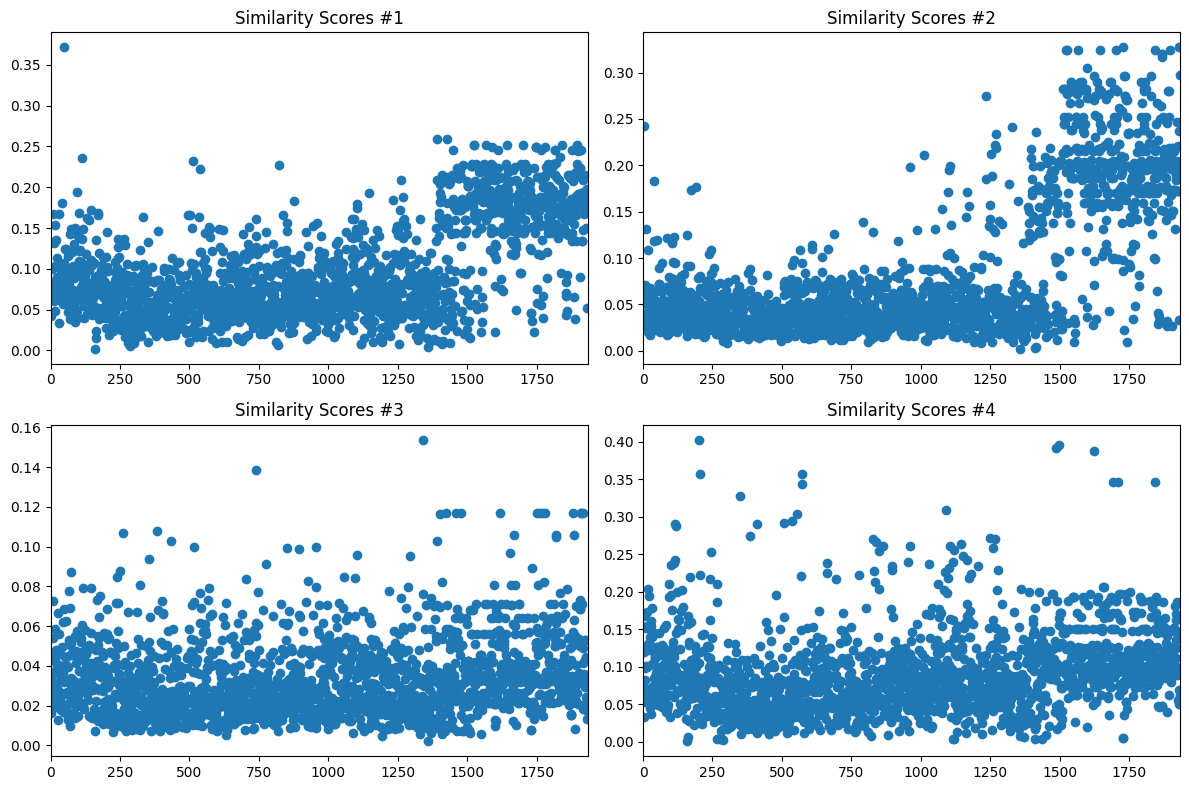

In [235]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Iterar a través de los 4 resultados y graficarlos en subplots separados
for i in range(4):
    scores_df = pd.DataFrame(similaridad_score_resultados[i], columns=['ItemID', 'Score'])
    ax = axs[i // 2, i % 2]  # Seleccionar el subplot adecuado
    ax.scatter(scores_df['ItemID'], scores_df['Score'])
    ax.set_title(f'Similarity Scores #{i+1}')
    ax.set_xlim(0, scores_df['ItemID'].max())

plt.tight_layout()
plt.show()


In [228]:
# Inicializa listas vacías para almacenar los resultados
final_results = []
# Itera a través de los 4 conjuntos de resultados
for producto in range(4):
    top_scores_product = [similarity_score[1] for similarity_score in similaridad_score_resultados[producto][:CANTIDAD]]
    top_item_ids_product = [similarity_score[0] for similarity_score in similaridad_score_resultados[producto][:CANTIDAD]]
    top_asin_product = asins_resultados[producto][:CANTIDAD]

    # Crear una lista de tuplas que contenga el ASIN, el score y el overall en el mismo orden
    data = list(zip(top_asin_product, top_scores_product, top_item_ids_product))

    # Crear un DataFrame a partir de los datos combinados
    df_result = pd.DataFrame(data, columns=['asin', 'Score', 'Id'])

    # Realizar un join entre df_result y result usando la columna 'ASIN' como clave de unión
    final_result = pd.merge(df_result, overall_mean, on='asin')
    final_results.append(final_result)



            asin     Score    Id   overall
0     B00005N7TG  0.371340    47  3.587302
1     B00D8GWHYA  0.259045  1390  3.269841
2     B00HG1BP0U  0.259045  1427  3.459259
3     B00SIC2JSI  0.251722  1524  2.000000
4     B00SIC2JY2  0.251722  1525  5.000000
...          ...       ...   ...       ...
1915  B002Y1K2YW  0.007512  1255  5.000000
1916  B00008WMD1  0.006536   819  4.200000
1917  B00006K5D5  0.005564   287  4.041667
1918  B00ADT5S9G  0.004177  1357  5.000000
1919  B00005R8BN  0.002153   160  4.016667

[1920 rows x 4 columns]
            asin     Score    Id   overall
0     B015HSVUKS  0.327111  1727  4.375000
1     B01HI8V10E  0.327111  1928  4.550000
2     B00SIC2JSI  0.324785  1524  2.000000
3     B00SIC2JY2  0.324785  1525  5.000000
4     B00VATZI1G  0.324785  1567  4.250000
...          ...       ...   ...       ...
1925  B001P79SQY  0.008906  1216  5.000000
1926  B00006KBSA  0.008458   302  5.000000
1927  B00G2GWEZU  0.004548  1414  3.666667
1928  B00FI9LOXU  0.003041  1

## MODULO 4
### Sistema de inferencia difuso

In [229]:
# Definimos las variables de entrada y salida para el sistema de control difuso
overall = ctrl.Antecedent(np.arange(1, 6, 0.1), 'overall')  # Calificación general
similaridad = ctrl.Antecedent(np.arange(-1, 1, 0.1), 'similaridad')  # Similaridad con otros elementos
recomendacion = ctrl.Consequent(np.arange(0, 2, 0.1), 'recomendacion')  # Recomendación resultante

# Definimos los trapecios para las variables de entrada y salida
overall['excelente'] = fuzz.trapmf(overall.universe, [4.1, 5, 5, 5]) # si el valor es [4.1 o 5], entonces es excelente
overall['bueno'] = fuzz.trapmf(overall.universe, [3.1, 4, 4, 4.1]) # si el valor es [3.1 o 4.1), entonces es bueno
overall['normal'] = fuzz.trapmf(overall.universe, [2.1, 3, 3, 3.1]) # si el valor es [2.1 o 3.1), entonces es normal
overall['pesimo'] = fuzz.trapmf(overall.universe, [0.99, 2, 2, 2.1]) # si el valor es (0.99 o 2.1), entonces es pesimo

similaridad['muy_similar'] = fuzz.trapmf(similaridad.universe, [0.7, 1, 1, 1]) # si el valor es [0.7 o 1], entonces es muy similar
similaridad['similar'] = fuzz.trapmf(similaridad.universe, [0.4, 0.7, 0.7, 0.7]) # si el valor es [0.4 o 0.7), entonces es similar
similaridad['poco_similar'] = fuzz.trapmf(similaridad.universe, [0.2, 0.4, 0.4, 0.4]) # si el valor es [0.2 o 0.4), entonces es poco similar
similaridad['no_similar'] = fuzz.trapmf(similaridad.universe, [-1, 0, 0, 0.2])  # si el valor es [-1 o 0.2), entonces es no similar


recomendacion['muy_recomendado'] = fuzz.trapmf(recomendacion.universe, [1.1, 2, 2, 2]) # si el valor es [1.1 o 2], entonces es muy recomendado
recomendacion['recomendado'] = fuzz.trapmf(recomendacion.universe, [0.1, 1, 1, 1.1]) # si el valor es [0.1 o 1.1), entonces es recomendado
recomendacion['no_recomendado'] = fuzz.trapmf(recomendacion.universe, [0, 0, 0, 0.1]) # si el valor es [0 o 0.1), entonces es no recomendado

# regla 1: si la similaridad es no similar y el overall es excelente, bueno, normal o pesimo, entonces la recomendacion es no recomendado
rule1 = ctrl.Rule(similaridad['no_similar'] & (overall['excelente'] | overall['bueno'] | overall['normal'] | overall['pesimo']), recomendacion['no_recomendado'])
# regla 2: si la similaridad es muy similar, similar, poco similar o no similar y el overall es pesimo, entonces la recomendacion es no recomendado
rule2 = ctrl.Rule(overall['pesimo'] & (similaridad['muy_similar'] | similaridad['similar'] | similaridad['poco_similar'] | similaridad['no_similar']), recomendacion['no_recomendado'])
# regla 3: si la similaridad es muy similar o similar y el overall es excelente o bueno, entonces la recomendacion es muy recomendado
rule3 = ctrl.Rule((overall['excelente'] | overall['bueno']) & (similaridad['muy_similar'] | similaridad['similar']), recomendacion['muy_recomendado'])
# regla 4: si la similaridad es muy similar o similar y el overall es normal, entonces la recomendacion es recomendado
rule4 = ctrl.Rule(overall['normal']  & (similaridad['muy_similar'] | similaridad['similar']), recomendacion['recomendado'])
# regla 5: si la similaridad es muy similar o similar y el overall es excelente o bueno y poco similar, entonces la recomendacion es recomendado
rule5 = ctrl.Rule((overall['excelente'] | overall['bueno']) & (similaridad['poco_similar']), recomendacion['recomendado'])
# regla 6: si la similaridad es poco similar y el overall es normal, entonces la recomendacion es no recomendado
rule6 = ctrl.Rule(overall['normal'] & similaridad['poco_similar'], recomendacion['no_recomendado'])

# Sistema de control y simulación
sistema_control = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6])
sistema_simulacion = ctrl.ControlSystemSimulation(sistema_control)

testeamos

In [230]:
# Pasar entradas al sistema
sistema_simulacion.input['overall'] = 4  # Ejemplo de calificación
sistema_simulacion.input['similaridad'] = 0.7  # Ejemplo de calificación
sistema_simulacion.compute() # Defuzzificación

# Por el metodo 'centroide'
print(sistema_simulacion.output['recomendacion'])

1.6333333333333335


## MODULO 5
### Defusificador

Defuzzificamos el resultado

In [231]:
def sistema_recomendacion_defuzzificado (recomendacion):
    if recomendacion < 0.1:
        return 'no_recomendado'
    elif recomendacion < 1.1:
        return 'recomendado'
    else:
        return 'muy_recomendado'
    

In [232]:
def sistema_recomendacion( similarity, overall):
    sistema_simulacion.input['overall'] = overall  # Ejemplo de calificación
    sistema_simulacion.input['similaridad'] = similarity # Ejemplo de calificación
    sistema_simulacion.compute() # Defuzzificación
    return (sistema_recomendacion_defuzzificado(sistema_simulacion.output['recomendacion']),sistema_simulacion.output['recomendacion'] )

In [233]:
# Itera a través de los 4 conjuntos de resultados

for i in range(4):
   # Aplicar la función fuzzyReglas a cada fila y crear una nueva columna 'result'
    final_results[i]['result'] = final_results[i].apply(lambda row: sistema_recomendacion(row['Score'], row['overall']), axis=1) 

# Para mostrar el DataFrame resultante
for i, df_result in enumerate(final_results):
    sorted_results = final_results[i].sort_values(by='result', key=lambda x: x.apply(lambda y: y[1] if isinstance(y, tuple) else y), ascending=False)




In [234]:
for i in range(4):
    producto_encontrado = df_meta_cortado.loc[df_meta_cortado['asin'] == random_asin_valores[i], ['asin', 'title', 'description']] 
    print("Producto seleccionado: ")
    display(producto_encontrado)
    resultado_completo = pd.merge(final_results[i], df_meta_cortado, on='asin')[['asin', 'title', 'description']]
    print("Productos recomendados:")
    display(resultado_completo.head(5))


Producto seleccionado: 


,asin,title,description
3013,B00XII1UBE,"<span class=""a-size-medium a-color-secondary""",[Long synonymous with sophistication and glamo...


Productos recomendados:


,asin,title,description
0,B00005N7TG,"<span class=""a-size-medium a-color-secondary""",[Vogue is the fashion authority. Setting the s...
1,B00D8GWHYA,"<span class=""a-size-medium a-color-secondary""",[Glamour is for the woman who sets the directi...
2,B00HG1BP0U,"<span class=""a-size-medium a-color-secondary""",[Glamour is for the woman who sets the directi...
3,B00SIC2JSI,"<span class=""a-size-medium a-color-secondary""",[Elle is the world's largest fashion magazine ...
4,B00SIC2JY2,"<span class=""a-size-medium a-color-secondary""",[Elle is the world's largest fashion magazine ...


Producto seleccionado: 


,asin,title,description
3026,B00YQH9874,"<span class=""a-size-medium a-color-secondary""","[Cycle World, America's largest motorcycle med..."


Productos recomendados:


,asin,title,description
0,B015HSVUKS,"<span class=""a-size-medium a-color-secondary""","[Home improvement, decorating, entertaining, c..."
1,B01HI8V10E,"<span class=""a-size-medium a-color-secondary""","[Home improvement, decorating, entertaining, c..."
2,B00SIC2JSI,"<span class=""a-size-medium a-color-secondary""",[Elle is the world's largest fashion magazine ...
3,B00SIC2JY2,"<span class=""a-size-medium a-color-secondary""",[Elle is the world's largest fashion magazine ...
4,B00VATZI1G,"<span class=""a-size-medium a-color-secondary""",[Elle is the world's largest fashion magazine ...


Producto seleccionado: 


,asin,title,description
2639,B009WBQX9K,"<span class=""a-size-medium a-color-secondary""",[At Rattle our purpose is to publish the best ...


Productos recomendados:


,asin,title,description
0,B007TBWZ3I,"<span class=""a-size-medium a-color-secondary""","[Celebrating the Goddess in every woman, SageW..."
1,B00007JXIB,"<span class=""a-size-medium a-color-secondary""","[We are a magazine that is by fans, for fans w..."
2,B00HG1BOWO,"<span class=""a-size-medium a-color-secondary""",[WIRED makes sense of a world in constant tran...
3,B00N9KO2UM,"<span class=""a-size-medium a-color-secondary""",[WIRED makes sense of a world in constant tran...
4,B00O3IRBI4,"<span class=""a-size-medium a-color-secondary""",[WIRED makes sense of a world in constant tran...


Producto seleccionado: 


,asin,title,description
227,B000063XJR,"<span class=""a-size-medium a-color-secondary""","[Skilled builders share tips, techniques and t..."


Productos recomendados:


,asin,title,description
0,B000063XJH,"<span class=""a-size-medium a-color-secondary""",[The magazine for savvy woodworkers--from aspi...
1,B00PE3SNFM,"<span class=""a-size-medium a-color-secondary""","[, HGTV Magazine is one of the most popular pu..."
2,B00O9K26AY,"<span class=""a-size-medium a-color-secondary""",[HGTV Magazine is one of the most popular publ...
3,B00XUMIBHY,"<span class=""a-size-medium a-color-secondary""",[HGTV Magazine is one of the most popular publ...
4,B000063XJI,"<span class=""a-size-medium a-color-secondary""","[Hands-on advice, information and inspiration ..."
